In [1]:
import pandas as pd
import numpy as np

data = pd.read_excel("data/[cafe24]매출데이터_3_6.xlsx")
raw_data = data.copy()
# data.head(2)

<전체>  
- 고객id/customer_id
- 주문번호/order_num
- 주문일시
    - 주문날짜(년월일)/order_date
    - 주문시간(시분초)/order_hour
- 주문자 가입일
    - 가입일부터 지난 일수/join_days
- 주문자 생년월일
    - 나이/age
    - 연령대/age_group
- 주문자 주소
    - 시,도/order_city1
    - 서울 동/order_city2
- 수령인 주소
    - 시,도/receipt_city1
    - 서울 동/receipt_city2
    - 주문 주소 차이 여부/ord_rec_diff
- 상품명
    - 상품명/product_name
    - 동시 주문 개수/product_count
    - 프로모션 여부/promotion
- 총 상품구매금액/total_price
- 총 결제금액
    - 결제금액/payment_price
    - 할인금액/discount_price
- 결제일시
    - 결제일/payment_date
    - 주문일과 차이나는 시간/ord_pay_diff
- 배송비/delivery_fee
- 결제수단/payment_how

In [2]:
data.columns

Index(['주문번호', '주문일시', '주문자명', '주문자 가입일', '주문자 생년월일', '주문자 주소', '주문자 상세 주소',
       '수령인 주소', '수령인 상세 주소', '상품명(한국어 쇼핑몰)', '총 상품구매금액(KRW)', '총 결제금액(KRW)',
       '결제일시(입금확인일)', '총 배송비(KRW)', '결제수단'],
      dtype='object')

In [3]:
list_ = raw_data[raw_data['주문자 생년월일'].notnull()].reset_index(drop = 'index')
customer_list = list_[['주문자명','주문자 생년월일']].drop_duplicates().reset_index(drop = 'index')
customer_list['customer_id'] = customer_list.index
data = pd.merge(data,customer_list)

In [4]:
from datetime import date    

#주문날짜(년월일)
def change_date(data):
    if data is pd.NaT:
        pass
    return data.strftime("%Y-%m-%d")

#주문시간(시분초)
def change_hour(data):
    if data is pd.NaT:
        pass
    return data.strftime("%H:%M:%S")

#가입일부터 지난 일수
def join_days(order_day,join_day):
    temp = order_day - join_day
    return temp.days

#나이
def age(data):
    if data is pd.NaT:
        return 1000
    else:
        age = date.today().year - data.year + 1
        return age

#연령대
def age_g(data):
    
    if data >= 100:
        return '이상치'
    elif data >= 90:
        return '90대'
    elif data >= 80:
        return '80대'
    elif data >= 70:
        return '70대'
    elif data >= 60:
        return '60대'
    elif data >= 50:
        return '50대'
    elif data >= 40:
        return '40대'
    elif data >= 30:
        return '30대'
    elif data >= 20:
        return '20대'

# 동시 구매 개수
def product_count(input_data):
    return (data['주문번호'] == input_data).sum()

# 프로모션
def promotion_product(data):
    if '프로모션'in data:
        return 1
    else:
        return 0
    
# 할인금액
def discount_price(total_price, delivery_fee, payment_price):
    return total_price + delivery_fee - payment_price

# 결제일
def payment_day(data):
    if data is pd.NaT:
        pass
    else:
        return data.strftime("%Y-%m-%d")
    
# 주문일 결제일 차이
def ord_pay_diff(order_day,payment_day):
    temp = payment_day - order_day
    return temp.days

data['order_date'] = data['주문일시'].apply(change_date)
data['order_hour'] = data['주문일시'].apply(change_hour)
data['join_days'] = data.apply(lambda x: join_days(x['주문일시'],x['주문자 가입일']),axis = 1)
data['age'] = data['주문자 생년월일'].apply(age)
data['age_group'] = data['age'].apply(age_g)
data['product_count'] = data['주문번호'].apply(product_count)
data['promotion'] = data['상품명(한국어 쇼핑몰)'].apply(promotion_product)
data['discount_price'] = data.apply(lambda x: discount_price(x['총 상품구매금액(KRW)'],x['총 배송비(KRW)'],x['총 결제금액(KRW)']),axis = 1)
data['payment_date'] = data['결제일시(입금확인일)'].apply(payment_day)
data['ord_pay_diff'] = data.apply(lambda x: ord_pay_diff(x['주문일시'],x['결제일시(입금확인일)']),axis = 1)

rename_dic = {'주문번호':'order_num', 
              '상품명(한국어 쇼핑몰)':'product_name',
              '총 상품구매금액(KRW)':'total_price', 
              '총 결제금액(KRW)':'payment_price',
              '총 배송비(KRW)':'delivery_fee',
              '결제수단':'payment_how'}

data.rename(columns = rename_dic, inplace = True)

In [5]:
columns_list = ['customer_id','order_num','order_date','order_hour','join_days','age','age_group','product_name','product_count','promotion',\
                'total_price','payment_price','discount_price','payment_date','ord_pay_diff','delivery_fee','payment_how']

data = data[columns_list]
data.head()

,customer_id,order_num,order_date,order_hour,join_days,age,age_group,product_name,product_count,promotion,total_price,payment_price,discount_price,payment_date,ord_pay_diff,delivery_fee,payment_how
0,0,20200301-0000036,2020-03-01,01:00:00,1637,35,30대,핑크원더 호호바오일 토너,1,0,42000,44500,0,2020-03-01,0.0,2500,신용카드
1,0,20200403-0000076,2020-04-03,00:25:43,1670,35,30대,핑크원더 호호바오일 50ml,1,0,272000,271580,420,2020-04-03,0.0,0,"적립금,신용카드"
2,1,20200301-0000043,2020-03-01,02:39:24,2,46,40대,핑크원더 호호바오일 토너,1,0,42000,44500,0,2020-03-01,0.0,2500,신용카드
3,2,20200301-0000105,2020-03-01,09:00:25,6,35,30대,핑크원더 호호바오일 토너,1,0,42000,44500,0,2020-03-01,0.0,2500,휴대폰
4,2,20200401-0000056,2020-04-01,00:52:02,37,35,30대,핑크원더 호호바오일 토너,1,0,33600,36100,0,2020-04-01,0.0,2500,휴대폰


주소 관련 데이터 나중에 수정

# 일별 구매 건수

1.결제 실패 제외

In [6]:
data_z = data[data['payment_price'] != 0].reset_index(drop = 'index')
print(len(data_z))

5536


2.프로모션 합하기

In [7]:
pro_sum = data_z.groupby('order_num')['promotion'].sum()
temp = pd.DataFrame({'order_num':pro_sum.index, 'promotion_sum':pro_sum.values})

data_g1 = pd.merge(data_z, temp)
data_g1.head(2)

,customer_id,order_num,order_date,order_hour,join_days,age,age_group,product_name,product_count,promotion,total_price,payment_price,discount_price,payment_date,ord_pay_diff,delivery_fee,payment_how,promotion_sum
0,0,20200301-0000036,2020-03-01,01:00:00,1637,35,30대,핑크원더 호호바오일 토너,1,0,42000,44500,0,2020-03-01,0.0,2500,신용카드,0
1,0,20200403-0000076,2020-04-03,00:25:43,1670,35,30대,핑크원더 호호바오일 50ml,1,0,272000,271580,420,2020-04-03,0.0,0,"적립금,신용카드",0


3.일별 구매 건수 나열

In [8]:
temp = data_g1.drop(['customer_id','product_name','promotion'],axis = 1)
data_g = temp.drop_duplicates().reset_index(drop = 'index')

print(len(data_g))
data_g.head()

4544


,order_num,order_date,order_hour,join_days,age,age_group,product_count,total_price,payment_price,discount_price,payment_date,ord_pay_diff,delivery_fee,payment_how,promotion_sum
0,20200301-0000036,2020-03-01,01:00:00,1637,35,30대,1,42000,44500,0,2020-03-01,0.0,2500,신용카드,0
1,20200403-0000076,2020-04-03,00:25:43,1670,35,30대,1,272000,271580,420,2020-04-03,0.0,0,"적립금,신용카드",0
2,20200301-0000043,2020-03-01,02:39:24,2,46,40대,1,42000,44500,0,2020-03-01,0.0,2500,신용카드,0
3,20200301-0000105,2020-03-01,09:00:25,6,35,30대,1,42000,44500,0,2020-03-01,0.0,2500,휴대폰,0
4,20200401-0000056,2020-04-01,00:52:02,37,35,30대,1,33600,36100,0,2020-04-01,0.0,2500,휴대폰,0


In [9]:
# 검수
data_g['order_num'].duplicated().sum()

0

In [10]:
data_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4544 entries, 0 to 4543
Data columns (total 15 columns):
order_num         4544 non-null object
order_date        4544 non-null object
order_hour        4544 non-null object
join_days         4544 non-null int64
age               4544 non-null int64
age_group         4540 non-null object
product_count     4544 non-null int64
total_price       4544 non-null int64
payment_price     4544 non-null int64
discount_price    4544 non-null int64
payment_date      4544 non-null object
ord_pay_diff      4544 non-null float64
delivery_fee      4544 non-null int64
payment_how       4544 non-null object
promotion_sum     4544 non-null int64
dtypes: float64(1), int64(8), object(6)
memory usage: 532.6+ KB


- payment_price
- join_days
- age
- product_count
- discount_price
- ord_pay_diff
- delivery_fee
- promotion_sum

In [11]:
test = data_g[['payment_price','join_days','age','product_count','discount_price','ord_pay_diff','delivery_fee','promotion_sum']]

<Figure size 1440x1080 with 0 Axes>

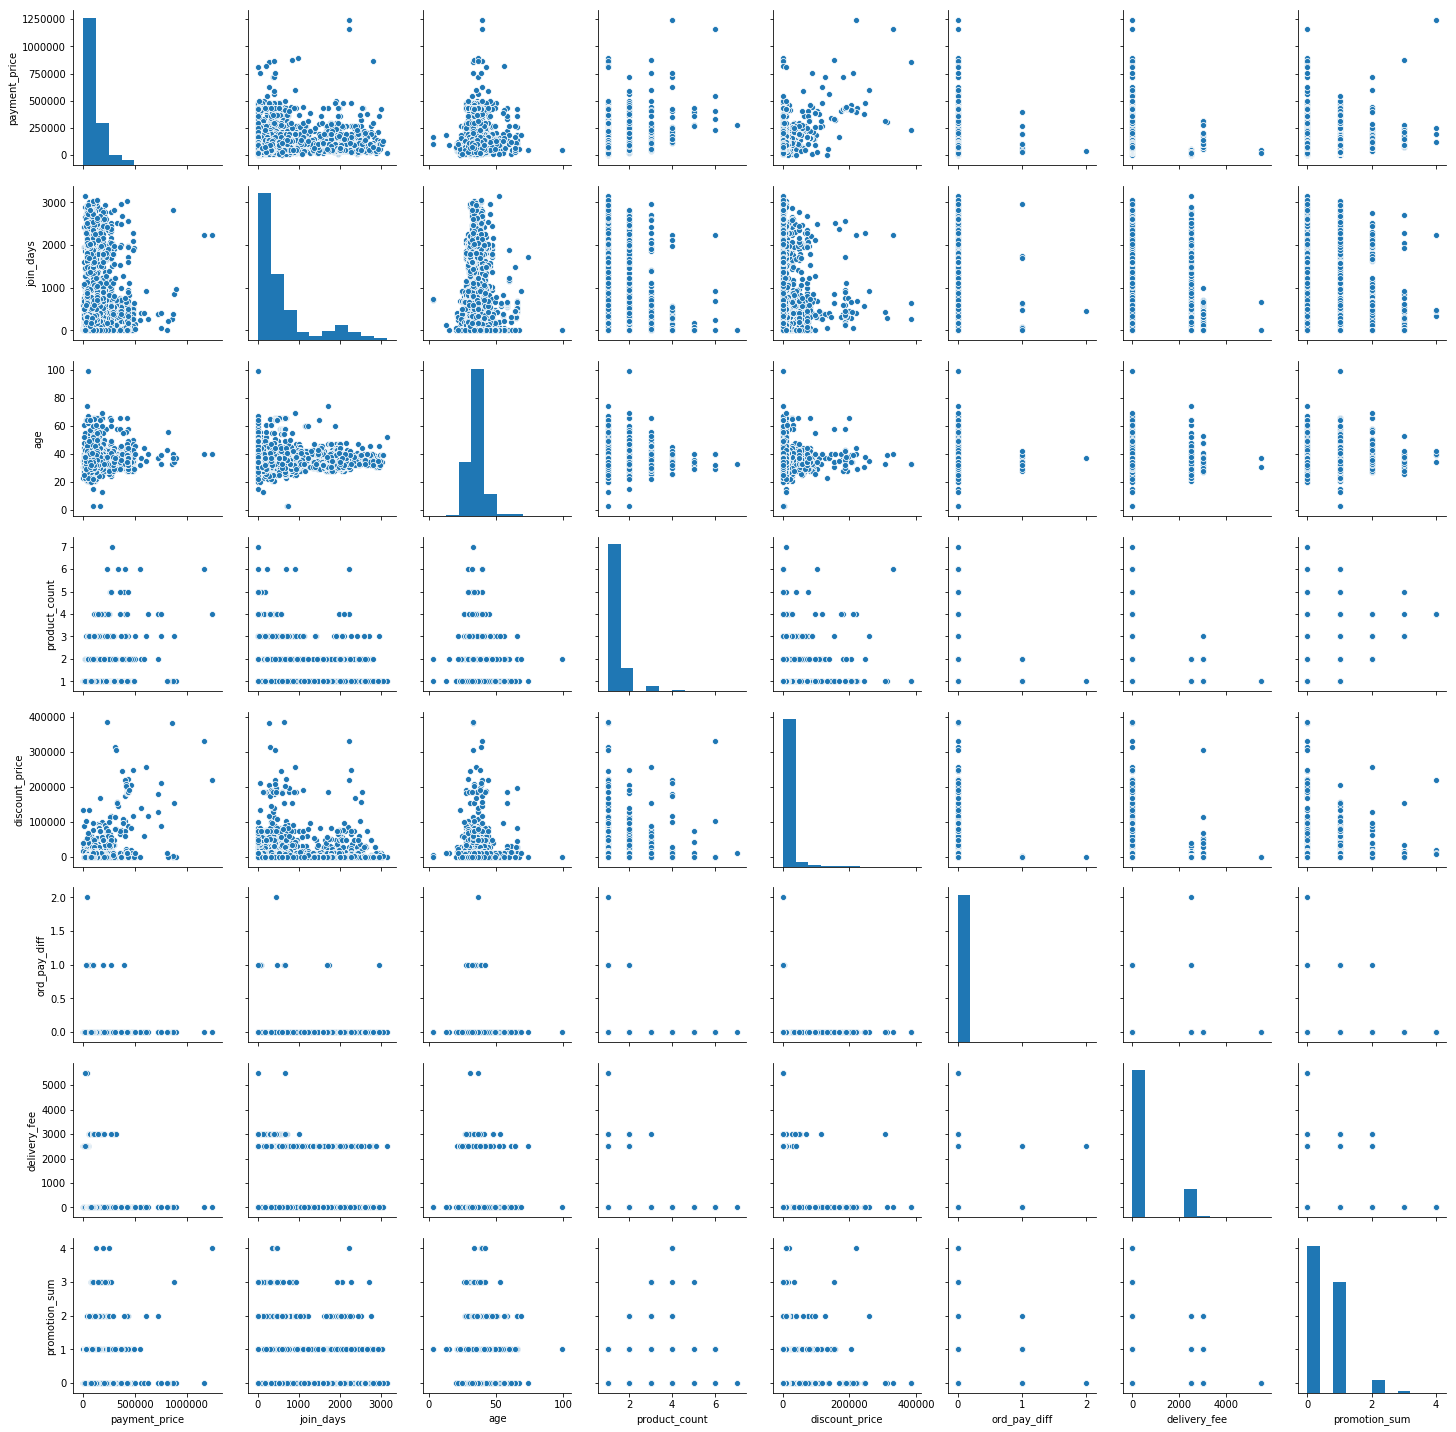

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20,15))

sns.pairplot(test)